# Coronavirus Prevalence

On April 22, Drs. Erickson and Massihi from Kern County California gave a press briefing where they detailed the testing statistics from their healthcare facilities and made some observations as to what they thought the fatality rate of coronavirus was. And they suggested lifting the lockdown. Their heterodox fatality estimates and policy recommendations were widely panned in the media and on twitter. Their press briefing was censored from Youtube for disagreeing with the health authorities.

The banned video is available here: https://www.turnto23.com/news/coronavirus/video-interview-with-dr-dan-erickson-and-dr-artin-massihi-taken-down-from-youtube

The video asks an important question: *How deadly is coronavirus?* 

Two measures of deadliness are:

- Case Fatality Rate (CFR): the rate at which people who test positive (i.e. confirmed cases) die.
- Infection Fatality Rate (IFR): the rate at which people infected with coronavirus die. 

These are very different because we don't test everyone and so cannot see exactly how many people have been infected. We know that many or most coronavirus infections are mild or asymptomatic and that these infections are rarely tested. Initial testing focused on diagnosing people who were seriously ill and coming into the healthcare system for treatment. As time passes, testing is broadening to include testing vulnerable and at risk populations more widely, including testing entire long-term care facilities or prisons, or healthcare facility staff, or frontline workers like police officers.

During the month of February the Diamond Princess cruise ship was languishing in port in Japan, having a widespread outbreak of coronavirus. Everyone on the ship was tested. This is some of the earliest data that provided an estimate of the Infection Fatality Rate. On March 26th, Nature published the Infecton Fatality Rate estimate of 0.5% (https://www.nature.com/articles/d41586-020-00885-w):

> The group also estimates that the infection fatality rate (IFR) in China — the proportion of all infections, including asymptomatic ones, that result in death — is even lower, at roughly 0.5%. The IFR is especially tricky to calculate in the population, because some deaths go undetected if the person didn’t show symptoms or get tested.

In late April, several antibody seroprevalence studies were done in the United States, one in Santa Clara (CA) county, one in LA county (CA), one in Miami Dade County (FL) and one in New York state. The IFR implied by the New York study was also 0.5%.


In [200]:
import datetime
import itertools
from pprint import pprint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import pandas as pd
from pandas import to_datetime
from pathlib import Path
import plotly.express as px
from scipy.special import gamma
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression
import time
import timeit

from IPython.display import HTML 

from coronavirus.data import (
    load_cdc_deaths_by_age,
    load_census_state_population_by_age_data,
    load_covidtracking_state_data, 
    load_nyc_age_comorbidity_death_data, 
    fill_before_first, before_threshold, make_days_since,
    add_derived_values_cols,
#     to_prevalence_dataframe,
#     to_prevalence_age_dataframe,
    add_age_dimension,
    add_herd_cols,
    add_herd_dimension,
    add_prevalence_age_cols,
    add_prevalence_cols,
    add_prevalence_dimension,
)
from coronavirus.viz import plot_trajectories, days_since_trim, prioritize_entities

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [174]:
states_df = (load_covidtracking_state_data(download=False, cache=True)
             .pipe(add_derived_values_cols))
states_df.groupby('entity').last().head()


,date,cases,deaths,tests,population,cases_per_million,cases_per_day,cases_per_day_7day_avg,cases_per_day_3day_avg,cases_per_million_per_day,...,deaths_per_test,deaths_per_day_3day_avg_tests_per_day_3day_avg_ratio,deaths_per_day_7day_avg_tests_per_day_7day_avg_ratio,deaths_per_test_per_day,deaths_per_test_per_day_3day_avg,deaths_per_test_per_day_7day_avg,deaths_per_day_3day_avg_tests_per_day_3day_avg_ratio_14day_ratio,deaths_per_test_per_day_3day_avg_14day_ratio,deaths_per_day_7day_avg_tests_per_day_7day_avg_ratio_14day_ratio,deaths_per_test_per_day_7day_avg_14day_ratio
entity,,,,,,,,,,,,,,,,,,,,,
Alabama,2020-05-04,8025.0,296.0,103117.0,4903185,1636.691253,300.0,218.000000,289.000000,61.184720,...,0.002871,0.001520,0.002541,0.000565,1.334889e-02,0.008185,0.532142,5.554644e-01,0.624764,0.578218
Alaska,2020-05-04,370.0,9.0,21723.0,731545,505.778865,2.0,3.571429,2.000000,2.733940,...,0.000414,0.000000,0.000000,0.000000,1.156482e-18,0.000000,0.000000,1.797174e-15,0.000000,0.000000
Arizona,2020-05-04,8919.0,362.0,85253.0,7278717,1225.353314,279.0,314.714286,319.000000,38.330931,...,0.004246,0.003085,0.004650,0.000000,3.419079e-03,0.006712,0.903112,1.026397e+00,0.797855,1.037789
Arkansas,2020-05-04,3458.0,81.0,54442.0,3017804,1145.866332,27.0,63.000000,45.666667,8.946903,...,0.001488,0.003567,0.002217,0.003222,3.412386e-03,0.003435,2.182249,3.218159e-01,1.061965,0.588810
California,2020-05-04,54937.0,2254.0,747874.0,39512223,1390.379883,1321.0,1639.000000,1498.333333,33.432692,...,0.003014,0.001949,0.002566,0.001214,1.938023e-03,0.002636,0.276871,1.776284e-01,0.425623,-0.245519


## Age and Fatality

How old are people dying of coronavirus?

- Less than 1% of deaths (in the USA) come from people less than 35 years old.
- Less than 2.8% of deaths come from people less than 45 years old.
- Less than 8% of deaths come from people less than 55 years old.
- Less than 20.5% of deaths come from people less than 65 years old.

New York City reports deaths and cases by age. This allows us to look at the case fatality rate by age in NYC. See below.

In [175]:
df = load_cdc_deaths_by_age(download=False, cache=True)
df

,date,entity,deaths,age_band,min_age,max_age,cumulative_deaths,cumulative_death_pct
15,04/25/2020,United States,4.0,Under 1 year,0,0,4.0,0.011587
16,04/25/2020,United States,2.0,1–4 years,1,4,6.0,0.017381
17,04/25/2020,United States,3.0,5–14 years,5,14,9.0,0.026071
18,04/25/2020,United States,39.0,15–24 years,15,24,48.0,0.139046
19,04/25/2020,United States,263.0,25–34 years,25,34,311.0,0.900901
20,04/25/2020,United States,647.0,35–44 years,35,44,958.0,2.775122
21,04/25/2020,United States,1776.0,45–54 years,45,54,2734.0,7.919817
22,04/25/2020,United States,4347.0,55–64 years,55,64,7081.0,20.512152
23,04/25/2020,United States,7419.0,65–74 years,65,74,14500.0,42.003418
24,04/25/2020,United States,9416.0,75–84 years,75,84,23916.0,69.279569


In [180]:
age_comorbidity_df, df = load_nyc_age_comorbidity_death_data(cache=True)
# df
# display(age_comorbidity_df)
print('New York City Case Fatality Rate by Age')
(df.loc[:, ['entity', 'age_band', 'deaths_per_case', 'deaths', 'cases']]
 .rename(columns={'deaths_per_case': 'case_fatality_rate'})
)

New York City Case Fatality Rate by Age


,entity,age_band,case_fatality_rate,deaths,cases
0,New York,0 to 17,0.001617,6,3711
1,New York,18 to 44,0.008495,507,59684
2,New York,45 to 64,0.046940,2803,59715
3,New York,65 to 74,0.152962,3101,20273
4,New York,75+,0.332433,6152,18506


## Comorbidity and Fatality

Comorbidity data is available for COVID-19 fatalilies from NYC and Massachusetts.

In NYC, 99.2% of deaths have a comorbidity. Source: https://www1.nyc.gov/site/doh/covid/covid-19-data.page

In Massachusetts, 98.2% of deaths have a comorbidity. Source: https://www.mass.gov/doc/covid-19-dashboard-april-30-2020/download.


In [185]:
df, _ = load_nyc_age_comorbidity_death_data(cache=True)
df = df.loc[lambda d: (d['comorbidity'] != 'unknown') & (d['age_band'] != 'unknown')]
df = df.pivot(index='age_band', columns='comorbidity', values='deaths')
df['total'] = df.sum(axis=1)
df['comorbidity_frac'] = df['yes'] / df['total']
print('Fraction of NYC deaths with a comorbidity:')
print(f"{(df['yes'].sum() / df['total'].sum()):.3f}\n")
print('Fraction of NYC deaths with a comorbidity by age:')
df

Fraction of NYC deaths with a comorbidity:
0.992

Fraction of NYC deaths with a comorbidity by age:


comorbidity,no,yes,total,comorbidity_frac
age_band,,,,
0 to 17,0,6,6,1.000000
18 to 44,14,401,415,0.966265
45 to 64,54,2363,2417,0.977658
65 to 74,4,2255,2259,0.998229
75+,1,4140,4141,0.999759


## Infection Fatality Rate by State

The Erickson estimate of prevalence is cases/tests. This is motivated by the goal of modeling the prevalence to get a better estimate of the infection fatality rate (IFR) of coronavirus. As a first approximation, assuming that people are tested at random (which they are not) leads to the Erickson estimate of prevalence.

The Erickson estimate of infection fatality rate is deaths / (population * prevalence). As a first approximation, assuming that reported deaths is a relatively accurate count leads to the Erickson estimate of infection fatality rate.

The adjusted Erickson estimate scales the Erickson estimate by a factor s.t the NY state adjusted estimate equals the NY seroprevalence study estimate of 12.3% on May 2nd.

Based on antibody seroprevalence study data, it looks like the case fatality rate is pessimistic by around a factor of 8 or 80 depending on the location and study results. Based on those studies it looks like the Erickson estimate is optimistic by around a factor of 2, based on New York state, the state which we have seroprevalance data for.

In [191]:
df = states_df
df = add_prevalence_dimension(df)
df = add_prevalence_cols(df)
df.head()


,date,entity,cases,deaths,tests,population,cases_per_million,cases_per_day,cases_per_day_7day_avg,cases_per_day_3day_avg,...,deaths_per_test_per_day,deaths_per_test_per_day_3day_avg,deaths_per_test_per_day_7day_avg,deaths_per_day_3day_avg_tests_per_day_3day_avg_ratio_14day_ratio,deaths_per_test_per_day_3day_avg_14day_ratio,deaths_per_day_7day_avg_tests_per_day_7day_avg_ratio_14day_ratio,deaths_per_test_per_day_7day_avg_14day_ratio,method,prevalence,ifr
0,2020-03-07,Alabama,0.0,NaN,0.0,4903185,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,confirmed,0.0,NaN
1,2020-03-07,Alabama,0.0,NaN,0.0,4903185,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,adjusted_confirmed,0.0,NaN
2,2020-03-07,Alabama,0.0,NaN,0.0,4903185,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,erickson,NaN,NaN
3,2020-03-07,Alabama,0.0,NaN,0.0,4903185,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,adjusted_erickson,NaN,NaN
4,2020-03-08,Alabama,0.0,NaN,0.0,4903185,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,confirmed,0.0,NaN


Here are the prevalence estimates and their corresponding infection fatality rates for New York. Note that the adjusted prevalence matches the NY state antibody seroprevalence survey results announced on 05/02.

In [192]:
HTML(df.loc[(df['entity'] == 'New York') & (df['date'] == to_datetime('2020-05-02')),
       ['date', 'entity', 'method', 'prevalence', 'ifr']]
     .to_html(index=False))

date,entity,method,prevalence,ifr
2020-05-02,New York,confirmed,0.016088,0.060417
2020-05-02,New York,adjusted_confirmed,0.123000,0.007902
2020-05-02,New York,erickson,0.326334,0.002979
2020-05-02,New York,adjusted_erickson,0.123000,0.007902


A plot of how the prevalence estimates have changed over time. The confirmed prevalence is cases / population size. The Erickson prevalence is cases / tests. The adjusted Erickson prevalance scales Erickson prevalence s.t. it equals the NY state serprevalence estimate released on 2020-05-02.

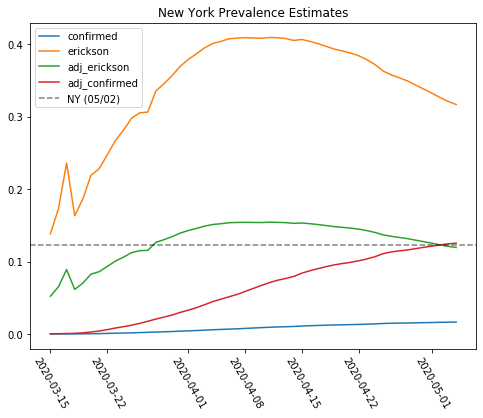

In [194]:
def plot_ny_prevalence_trend(df):
    entity = 'New York'
    df = df.loc[~before_threshold(df, col='date', thresh=to_datetime('2020-03-15'))]
    dates = df.loc[(df['entity'] == entity) & (df['method'] == 'confirmed'), 'date']
    confs = df.loc[(df['entity'] == entity) & (df['method'] == 'confirmed'), 'prevalence']
    erics = df.loc[(df['entity'] == entity) & (df['method'] == 'erickson'), 'prevalence']
    aes = df.loc[(df['entity'] == entity) & (df['method'] == 'adjusted_erickson'), 'prevalence']
    acs = df.loc[(df['entity'] == entity) & (df['method'] == 'adjusted_confirmed'), 'prevalence']
    plt.subplots(figsize=(8,6))
    plt.plot(dates, confs, label='confirmed')
    plt.plot(dates, erics, label='erickson')
    plt.plot(dates, aes, label='adj_erickson')
    plt.plot(dates, acs, label='adj_confirmed')
    ny_seroprevalence = 0.123
    plt.axhline(y=ny_seroprevalence, linestyle='--', color='k', alpha=0.5, label='NY (05/02)')
    # plt.axvline(x=pd.to_datetime('2020-05-02'), linestyle='--', color='k', alpha=0.5)
    plt.xticks(rotation=-60)
    plt.legend()
    plt.title(f'{entity} Prevalence Estimates')
    plt.show()
    
plot_ny_prevalence_trend(df)

#### Trends in Infection Fatality Rate Estimations by State

The next figure shows trends in infection fatality rate estimations by state. We can see that there is a broad range of IFR by state. 

Erickson IFR estimates show a strong increasing trend across most/all states. This is consistent with the estimate being an underestimate of IFR that is converging to the true value as more testing occurs.

Confirmed IFR (i.e. case fatality rate) estimates show variable trends, increasing for some states, stable for many states and decreasing somewhat for some states. This suggests that CFR is a more stable and less biased estimate over time than the Erickson estimate. It also suggests that the adjusted confirmed IFR estimate might be the best predictor of future IFR values.

Confirmed IFRs range from around 0.01 to 0.09, a 9-fold difference. Erickson IFRs range from around 0.0002 to 0.0030, a 15-fold difference. These ranges are very different. The adjusted ranges are much closer. Adjusted Confirmed IFRs range from around 0.001 to 0.012. Adjusted Erickson IFRs range from arond 0.0005 to 0.008. 

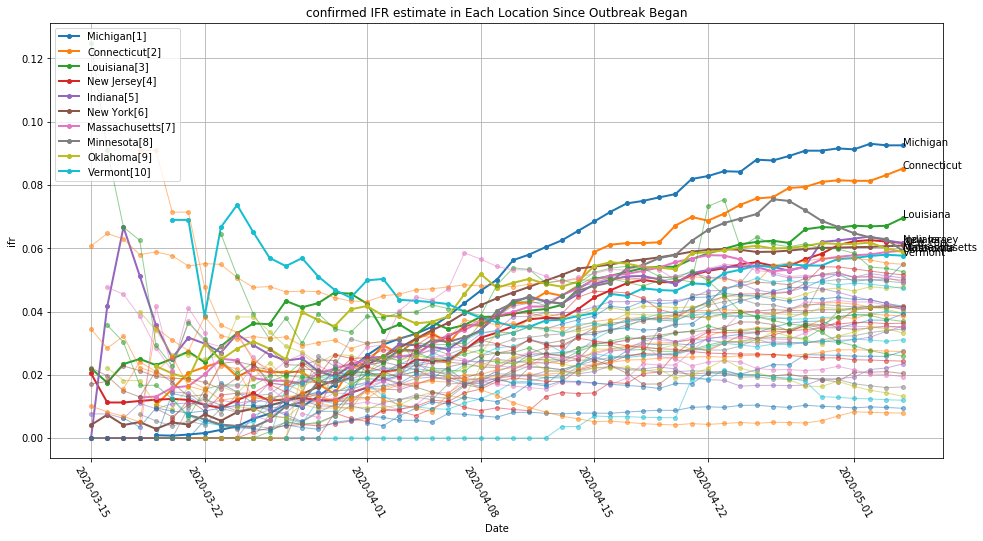

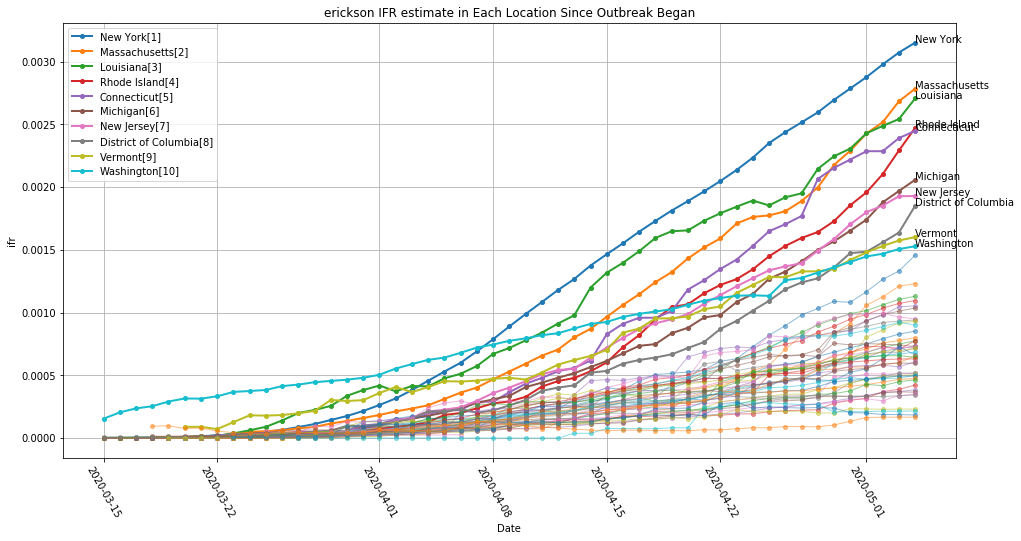

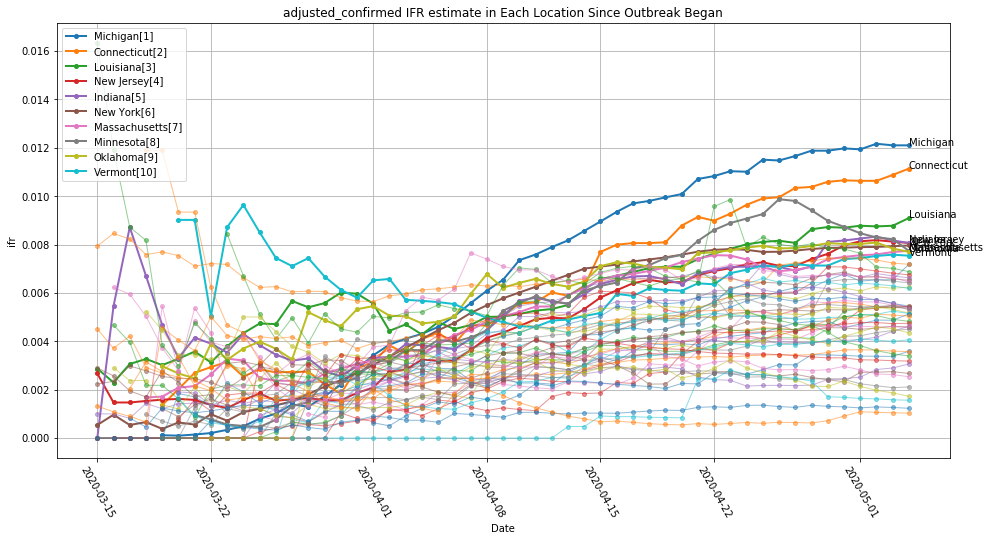

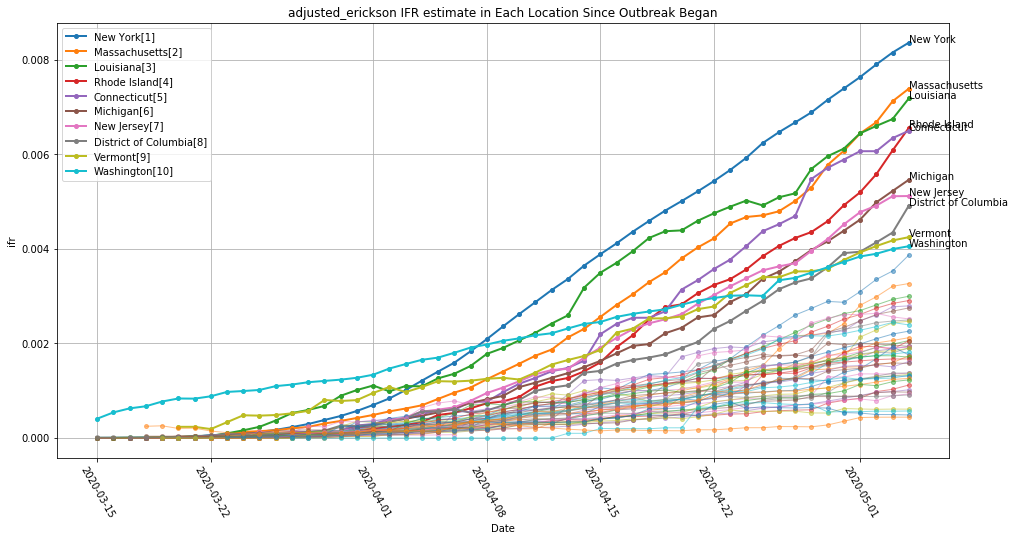

In [196]:
def plot_ifr_trend_by_state(df):
    index_col = 'date'; df = df.loc[~before_threshold(df, col='date', thresh=to_datetime('2020-03-15'))]
#     index_col = 'days_since'; df = df.loc[~before_threshold(df, col='deaths', thresh=5)].copy()
#     df['days_since'] = make_days_since(df, col='deaths', thresh=5)
    
    values_col='ifr'; log_yaxis = False; ascending = False; show_legend = True
    n_top = 10; n_show = 55; rank = False;
    method = 'confirmed'
    title = f'{method} IFR estimate in Each Location Since Outbreak Began'
    plot_trajectories(
        df.loc[(df['method'] == method)], index_col=index_col, values_col=values_col, n_top=n_top, n_show=n_show,
        log_yaxis=log_yaxis, ascending=ascending, show_legend=show_legend, title=title, rank=rank
    )
    method = 'erickson'
    title = f'{method} IFR estimate in Each Location Since Outbreak Began'
    plot_trajectories(
        df.loc[(df['method'] == method)], index_col=index_col, values_col=values_col, n_top=n_top, n_show=n_show,
        log_yaxis=log_yaxis, ascending=ascending, show_legend=show_legend, title=title, rank=rank
    )
    method = 'adjusted_confirmed'
    title = f'{method} IFR estimate in Each Location Since Outbreak Began'
    plot_trajectories(
        df.loc[(df['method'] == method)], index_col=index_col, values_col=values_col, n_top=n_top, n_show=n_show,
        log_yaxis=log_yaxis, ascending=ascending, show_legend=show_legend, title=title, rank=rank
    )
    method = 'adjusted_erickson'
    title = f'{method} IFR estimate in Each Location Since Outbreak Began'
    plot_trajectories(
        df.loc[(df['method'] == method)], index_col=index_col, values_col=values_col, n_top=n_top, n_show=n_show,
        log_yaxis=log_yaxis, ascending=ascending, show_legend=show_legend, title=title, rank=rank
    )

plot_ifr_trend_by_state(df)

## Infection Fatality Rate and Herd Immunity

At what prevalence will herd immunity to coronavirus be achieved?

- https://www.weforum.org/agenda/2020/05/coronavirus-pandemic-last-2-years/
  - herd immunity at 60%-70% prevalence. 
  - [the report](https://www.cidrap.umn.edu/sites/default/files/public/downloads/cidrap-covid19-viewpoint-part1_0.pdf)

Theoretically, herd immunity works by having immune individuals get in the way of the virus moving from an infected person to a susceptible one. The prevalence of immune people lowers R, the repoduction number of the virus. This is also what social distancing does. What is the R0 (the basic reproduction number) of coronavirus? We want to examine a range of possible reproduction (R) numbers and their corresponding herd immunity prevalences. 

- https://academic.oup.com/cid/article/52/7/911/299077 
  - Details the relationship between R0 and the corresponding recovered prevalence.
  - figure: [(H)erd rate vs R0](https://academic.oup.com/view-large/figure/3862687/cidcir007f02_ht.gif).
  - 40%-80% prevalence for herd immunity, depending on what the R0 of coronavirus.

So what is the most likely value of R0? Around 2-2.5 according to [this NY Times article](https://www.nytimes.com/2020/04/23/world/europe/coronavirus-R0-explainer.html). Eyeballing the [(H)erd rate vs R0](https://academic.oup.com/view-large/figure/3862687/cidcir007f02_ht.gif), it looks like the corresponding recovered prevalence at herd immunity is 45-60%.

What is R0, the basic reproduction number? It a measure of virality that assumes everyone is susceptible and no mitigation is occurring. https://en.wikipedia.org/wiki/Basic_reproduction_number. The effective reproduction number, R, can take into account recovered individuals, social distancing measures, weather. What this means is that herd immunity can be achieved at *lower recovered prevalences* corresponding to a lower R. Nicky Case has a great piece describing this: https://ncase.me/covid-19/. If R is 1.5, herd immunity could be achieved with 35% recovered.

What determines R? Summer weather, small gatherings, handwashing, and masks would all reduce R down from R0. 

The effective reproduction number can be thought of as a function of R0, the weather, social distancing, work-from-home, masks, stay-at-home orders, contact tracing, surveillance testing, temperature testing.

$$
R = R_0 + R_\text{biology} + R_\text{weather} + R_\text{social_distancing} + R_\text{stay_at_home} + ...
$$

*DATA NEEDED: what are the contributions to R of different policies?*

This analysis assumes that the current fatality rates hold. If vulnerable populations are protected or therapeutics are developed, the fatality rate would improve. Protecting the vulnerable could be approximated as reducing the proportion of the 65-74 and 75+ age bands that get infected at a herd prevalence level. Therapeutics could be modeled by reducing the IFR across all age bands, by reducing the number of deaths by a therapeutic factor like 0.9 or 0.5.

As the prevalence of infections rises to a level where herd immunity is achieved, people of all ages will become infected and some of them will die. Here we consider a range of herd immunity prevalences. Prevalence of immune individuals is on factor in the R equation.




In [250]:
df = states_df
df = add_prevalence_dimension(df)
df = add_prevalence_cols(df)
df = add_herd_dimension(df)
df = add_herd_cols(df)
df[df['entity'] == 'California'].tail(20).loc[:, [
    'date', 'entity', 'method', 'herd', 'cases', 'deaths', 'prevalence', 'ifr', 
    'herd_deaths', 'herd_deaths_per_million',
]]

,date,entity,method,herd,cases,deaths,prevalence,ifr,herd_deaths,herd_deaths_per_million
3616,2020-05-03,California,adjusted_confirmed,0.6,53616.0,2215.0,0.010374,0.005404,1.281062e+05,3242.192309
3617,2020-05-03,California,adjusted_confirmed,0.8,53616.0,2215.0,0.010374,0.005404,1.708083e+05,4322.923079
3618,2020-05-03,California,erickson,0.4,53616.0,2215.0,0.074909,0.000748,1.182773e+04,299.343485
3619,2020-05-03,California,erickson,0.6,53616.0,2215.0,0.074909,0.000748,1.774159e+04,449.015228
3620,2020-05-03,California,erickson,0.8,53616.0,2215.0,0.074909,0.000748,2.365545e+04,598.686970
3621,2020-05-03,California,adjusted_erickson,0.4,53616.0,2215.0,0.028234,0.001985,3.138035e+04,794.193564
3622,2020-05-03,California,adjusted_erickson,0.6,53616.0,2215.0,0.028234,0.001985,4.707053e+04,1191.290346
3623,2020-05-03,California,adjusted_erickson,0.8,53616.0,2215.0,0.028234,0.001985,6.276071e+04,1588.387128
3624,2020-05-04,California,confirmed,0.4,54937.0,2254.0,0.001390,0.041029,6.484559e+05,16411.525930
3625,2020-05-04,California,confirmed,0.6,54937.0,2254.0,0.001390,0.041029,9.726838e+05,24617.288895


In [213]:
dj = df.groupby(['entity', 'method', 'herd']).last().reset_index()
dk = dj.groupby(['method', 'herd']).agg(
    population=('population', 'sum'),
    herd_prevalence=('herd', 'mean'),
    herd_deaths=('herd_deaths', 'sum'),
).reset_index()
dk['herd_deaths_per_million'] = (1000000 * dk['herd_deaths'] / dk['population']).round()
dk['herd_deaths'] = dk['herd_deaths'].round()
print('United States Coronavirus Deaths At Herd Immunity Prevalence')
HTML(dk.set_index(['method', 'herd']).to_html())# to_html(index=False))


United States Coronavirus Deaths At Herd Immunity Prevalence


## Estimates of Infection Fatality Rate by Age

Segmenting the infection fatality rate by age requires knowing:

- the prevalence of infection. We have 3 estimates: confirmed_prevalence, erickson_prevalence, and adjusted_erickson_prevalence.
- population of the age band. We have estimates for population by state (or county) and census age_groups, or nyc_age_bands, or ma_age_bands.
- ifr_age = deaths_age * (population_age * prevalence)
- prevalence at state-level is available through: confirmed, erickson, adjusted, otherwise-modeled, ny antibody seroprevalence studies, county seroprevalence studies.
- deaths by age band. We have data for:
  - NYC
  - Massachusetts
  - ...more every day?

In [251]:
pop = load_census_state_population_by_age_data(bands='nyc')
pop[pop['entity'] == 'New York']

,entity,age_band,population
160,New York,0 to 17,4090613.0
161,New York,18 to 44,7088312.0
162,New York,45 to 64,5149750.0
163,New York,65 to 74,1809120.0
164,New York,75+,1404414.0


In [252]:
_, dc = load_nyc_age_comorbidity_death_data()
dc
dc[dc['entity'] == dc['entity'].iloc[0]]

,age_band,min_age,max_age,cases,deaths,deaths_per_case,entity
0,0 to 17,0.0,17.0,3711,6,0.001617,New York
1,18 to 44,18.0,44.0,59684,507,0.008495,New York
2,45 to 64,45.0,64.0,59715,2803,0.046940,New York
3,65 to 74,65.0,74.0,20273,3101,0.152962,New York
4,75+,75.0,200.0,18506,6152,0.332433,New York


In [253]:
df = states_df
df = add_prevalence_dimension(df)
df = add_age_dimension(df, pop, dc)
df = add_prevalence_age_cols(df)
df

,date,entity,cases,deaths,tests,population,cases_per_million,cases_per_day,cases_per_day_7day_avg,cases_per_day_3day_avg,...,min_age,max_age,cases_age,deaths_age,deaths_per_case_age,entity_age,cases_age_frac,deaths_age_frac,prevalence,ifr
0,2020-03-07,Alabama,0.0,NaN,0.0,4903185,0.000000,NaN,NaN,NaN,...,0.0,17.0,3711,6,0.001617,New York,0.022923,0.000477,0.000000,NaN
1,2020-03-07,Alabama,0.0,NaN,0.0,4903185,0.000000,NaN,NaN,NaN,...,0.0,17.0,3711,6,0.001617,New York,0.022923,0.000477,0.000000,NaN
2,2020-03-07,Alabama,0.0,NaN,0.0,4903185,0.000000,NaN,NaN,NaN,...,0.0,17.0,3711,6,0.001617,New York,0.022923,0.000477,NaN,NaN
3,2020-03-07,Alabama,0.0,NaN,0.0,4903185,0.000000,NaN,NaN,NaN,...,0.0,17.0,3711,6,0.001617,New York,0.022923,0.000477,NaN,NaN
4,2020-03-08,Alabama,0.0,NaN,0.0,4903185,0.000000,0.0,NaN,NaN,...,0.0,17.0,3711,6,0.001617,New York,0.022923,0.000477,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62535,2020-05-03,Wyoming,579.0,7.0,10219.0,578759,1000.416408,13.0,31.000000,11.666667,...,75.0,200.0,18506,6152,0.332433,New York,0.114313,0.489458,0.012206,0.007544
62536,2020-05-04,Wyoming,586.0,7.0,10454.0,578759,1012.511253,7.0,30.857143,9.000000,...,75.0,200.0,18506,6152,0.332433,New York,0.114313,0.489458,0.001800,0.051147
62537,2020-05-04,Wyoming,586.0,7.0,10454.0,578759,1012.511253,7.0,30.857143,9.000000,...,75.0,200.0,18506,6152,0.332433,New York,0.114313,0.489458,0.013764,0.006690
62538,2020-05-04,Wyoming,586.0,7.0,10454.0,578759,1012.511253,7.0,30.857143,9.000000,...,75.0,200.0,18506,6152,0.332433,New York,0.114313,0.489458,0.032039,0.002874


In [254]:
dg = df
(dg.groupby(['entity', 'method', 'age_band']).last().reset_index()
 .loc[lambda d: d['entity'].isin([
     'Massachusetts', 
     'New York',
     'Michigan'
     'Vermont', 
     'Florida', 
     'Utah'
 ]), :]
 .loc[lambda d: (d['method'].isin([
#      'confirmed', 
     'adjusted_confirmed'
 ])) 
#       & (d['age_band'] == '75+')
      , ['entity', 'method', 'age_band', 
#        'cases', 'deaths', 
          'prevalence', 'ifr', 'deaths_per_case']]
 .rename(columns={
     'deaths_per_case': 'case_fatality_rate',
     'ifr': 'infection_fatality_rate'
 })
)

# dg.tail(5)

,entity,method,age_band,prevalence,infection_fatality_rate,case_fatality_rate
180,Florida,adjusted_confirmed,0 to 17,0.001528,0.000105,0.038567
181,Florida,adjusted_confirmed,18 to 44,0.014628,0.000552,0.038567
182,Florida,adjusted_confirmed,45 to 64,0.018577,0.003050,0.038567
183,Florida,adjusted_confirmed,65 to 74,0.014732,0.009939,0.038567
184,Florida,adjusted_confirmed,75+,0.016451,0.021599,0.038567
420,Massachusetts,adjusted_confirmed,0 to 17,0.008695,0.000161,0.059201
421,Massachusetts,adjusted_confirmed,18 to 44,0.077587,0.000847,0.059201
422,Massachusetts,adjusted_confirmed,45 to 64,0.104708,0.004682,0.059201
423,Massachusetts,adjusted_confirmed,65 to 74,0.101164,0.015256,0.059201
424,Massachusetts,adjusted_confirmed,75+,0.124423,0.033155,0.059201


The following figures shows trends in adjusted_confirmed IFR for each different age band. They show the distribution across states and how these IFR values have changed over time.

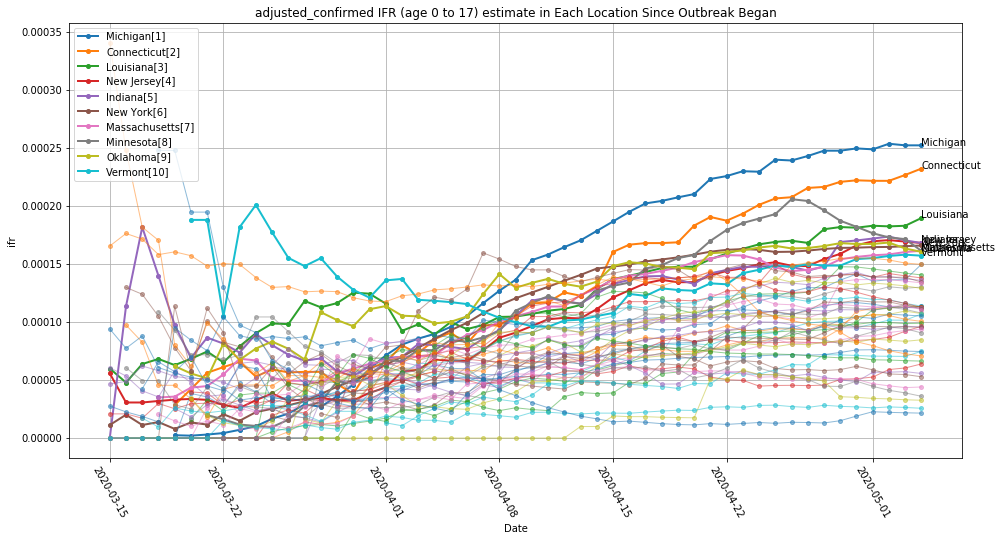

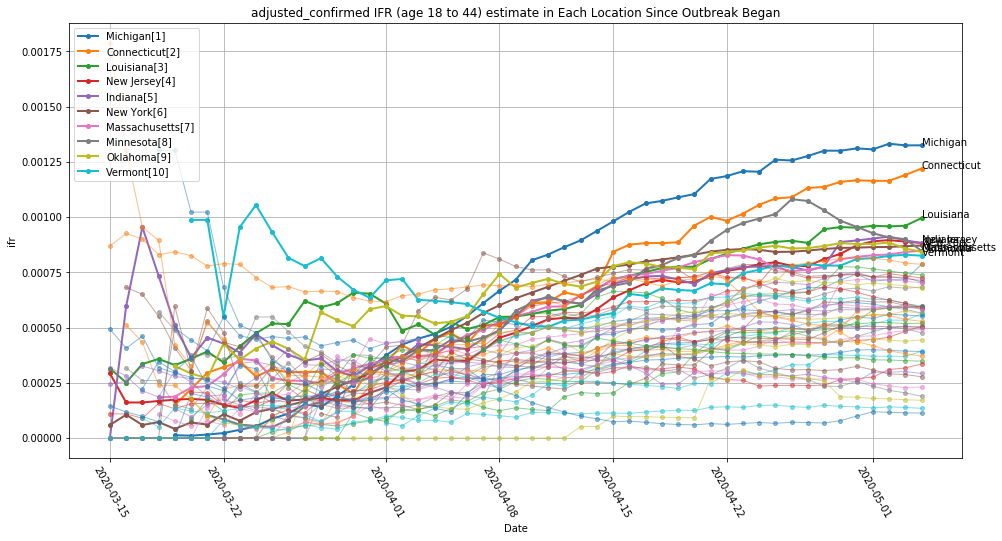

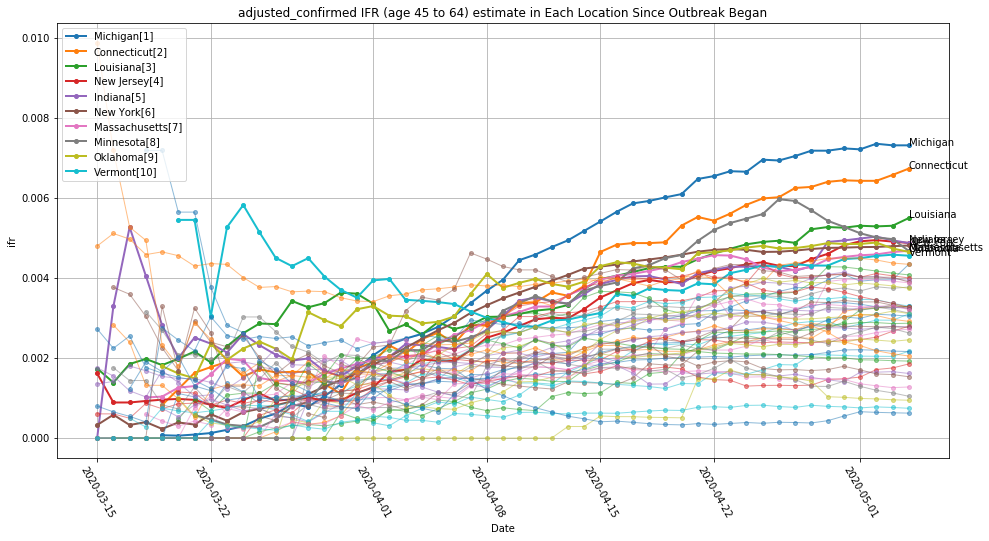

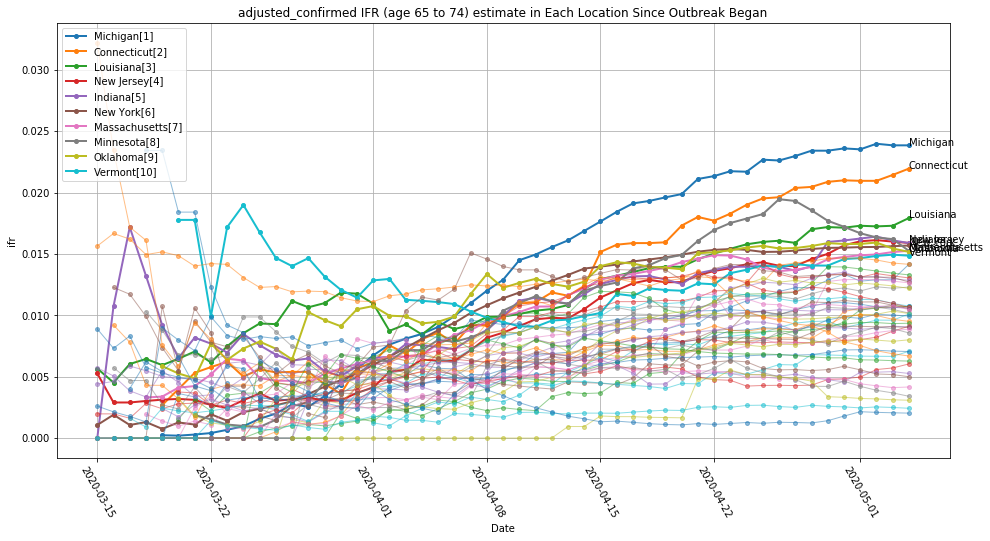

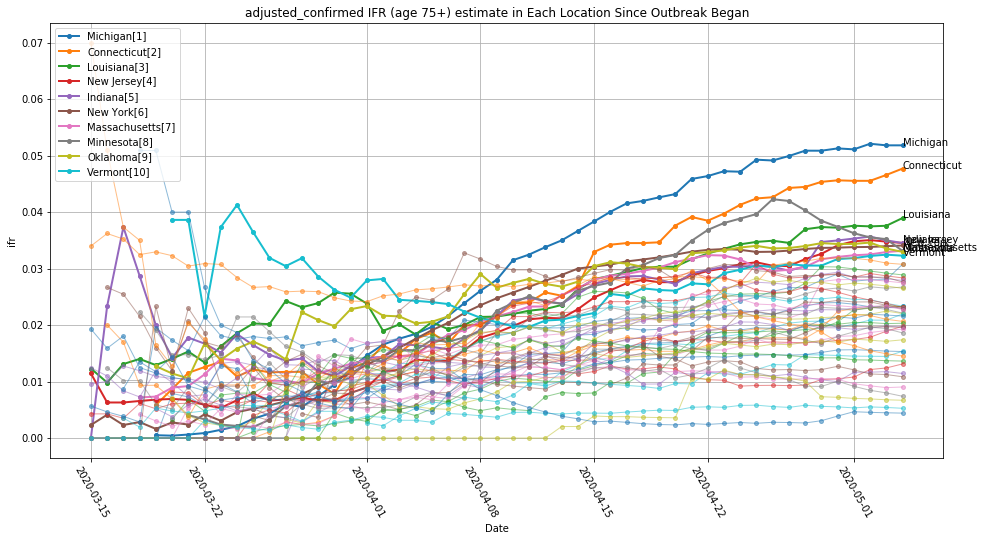

In [255]:
def plot_ifr_trend_by_state_and_age(df):
    index_col = 'date'; 
    df = df.loc[~before_threshold(df, col='date', thresh=to_datetime('2020-03-15'), 
                                  groupby=['entity', 'method', 'age_band'])]
    age_bands = df['age_band'].unique()
    
#     index_col = 'days_since'; df = df.loc[~before_threshold(df, col='deaths', thresh=5)].copy()
#     df['days_since'] = make_days_since(df, col='deaths', thresh=5)
    
    values_col='ifr'; log_yaxis = False; ascending = False; show_legend = True
    n_top = 10; n_show = 55; rank = False; method = 'adjusted_confirmed'
    
    for age_band in age_bands:
        title = f'{method} IFR (age {age_band}) estimate in Each Location Since Outbreak Began'
        plot_trajectories(
            df.loc[(df['method'] == method) & (df['age_band'] == age_band)],
            index_col=index_col, values_col=values_col, n_top=n_top, n_show=n_show,
            log_yaxis=log_yaxis, ascending=ascending, show_legend=show_legend, title=title, rank=rank
        )

plot_ifr_trend_by_state_and_age(dg)

In [256]:
dg.loc[(dg['date'] == to_datetime('2020-05-02')) & (dg['method'].isin(['confirmed', 'adjusted_confirmed'])), 
       ['date', 'entity', 'method', 'age_band', 'deaths_age_frac', 'deaths', 
        'cases_age_frac', 'cases', 'population', 'population_age', 
        'prevalence', 'ifr']
      ].sort_values(['date', 'entity', 'method', 'age_band']).tail(2)

,date,entity,method,age_band,deaths_age_frac,deaths,cases_age_frac,cases,population,population_age,prevalence,ifr
50020,2020-05-02,Wyoming,confirmed,65 to 74,0.246718,7.0,0.125228,566.0,578759,58168.0,0.001219,0.024366
62528,2020-05-02,Wyoming,confirmed,75+,0.489458,7.0,0.114313,566.0,578759,37207.0,0.001739,0.052954


## Infection Fatality Rate by Age and Herd Immunity



In [285]:
df = states_df
df = add_prevalence_dimension(df)
df = add_age_dimension(df, pop, dc)
df = add_prevalence_age_cols(df)
df = add_herd_dimension(df)
df = add_herd_cols(df, use_pop_age=True)

df[(df['entity'].isin(['Rhode Island']))
   & (df['date'] == to_datetime('2020-05-02'))
   & (df['method'] == 'adjusted_confirmed')
   & (df['herd'] == 0.4)
  ].tail(30).loc[:, [
    'date', 'entity', 'method', 'age_band', 'herd', 'cases', 'deaths', 'prevalence', 'ifr', 
    'herd_deaths', 'herd_deaths_per_million', 'population_age'
]]

,date,entity,method,age_band,herd,cases,deaths,prevalence,ifr,herd_deaths,herd_deaths_per_million,population_age
141927,2020-05-02,Rhode Island,adjusted_confirmed,0 to 17,0.4,9289.0,296.0,0.007718,0.000087,7.323290,34.719051,210930.0
142707,2020-05-02,Rhode Island,adjusted_confirmed,18 to 44,0.4,9289.0,296.0,0.069706,0.000456,68.515155,182.413759,375603.0
143487,2020-05-02,Rhode Island,adjusted_confirmed,45 to 64,0.4,9289.0,296.0,0.090790,0.002520,290.827306,1007.969093,288528.0
144267,2020-05-02,Rhode Island,adjusted_confirmed,65 to 74,0.4,9289.0,296.0,0.086683,0.008212,336.990374,3284.666645,102595.0
145047,2020-05-02,Rhode Island,adjusted_confirmed,75+,0.4,9289.0,296.0,0.101911,0.017846,568.651480,7138.571659,79659.0


In [277]:
dg = df.groupby(['entity', 'method', 'age_band', 'herd']).last().reset_index()
dg


,entity,method,age_band,herd,date,cases,deaths,tests,population,cases_per_million,...,deaths_age,deaths_per_case_age,entity_age,cases_age_frac,deaths_age_frac,prevalence,ifr,herd_cases,herd_deaths,herd_deaths_per_million
0,Alabama,adjusted_confirmed,0 to 17,0.4,2020-05-04,8025.0,296.0,103117.0,4903185,1636.691253,...,6,0.001617,New York,0.022923,0.000477,0.001289,0.000100,436402.4,43.844883,40.187572
1,Alabama,adjusted_confirmed,0 to 17,0.6,2020-05-04,8025.0,296.0,103117.0,4903185,1636.691253,...,6,0.001617,New York,0.022923,0.000477,0.001289,0.000100,654603.6,65.767324,60.281359
2,Alabama,adjusted_confirmed,0 to 17,0.8,2020-05-04,8025.0,296.0,103117.0,4903185,1636.691253,...,6,0.001617,New York,0.022923,0.000477,0.001289,0.000100,872804.8,87.689765,80.375145
3,Alabama,adjusted_confirmed,18 to 44,0.4,2020-05-04,8025.0,296.0,103117.0,4903185,1636.691253,...,507,0.008495,New York,0.368672,0.040337,0.013405,0.000528,674933.6,356.272722,211.145346
4,Alabama,adjusted_confirmed,18 to 44,0.6,2020-05-04,8025.0,296.0,103117.0,4903185,1636.691253,...,507,0.008495,New York,0.368672,0.040337,0.013405,0.000528,1012400.4,534.409083,316.718019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,Wyoming,erickson,65 to 74,0.6,2020-05-04,586.0,7.0,10454.0,578759,1012.511253,...,3101,0.152962,New York,0.125228,0.246718,0.035098,0.000846,34900.8,29.523275,507.551826
3056,Wyoming,erickson,65 to 74,0.8,2020-05-04,586.0,7.0,10454.0,578759,1012.511253,...,3101,0.152962,New York,0.125228,0.246718,0.035098,0.000846,46534.4,39.364366,676.735767
3057,Wyoming,erickson,75+,0.4,2020-05-04,586.0,7.0,10454.0,578759,1012.511253,...,6152,0.332433,New York,0.114313,0.489458,0.032039,0.002874,14882.8,42.775322,1149.657920
3058,Wyoming,erickson,75+,0.6,2020-05-04,586.0,7.0,10454.0,578759,1012.511253,...,6152,0.332433,New York,0.114313,0.489458,0.032039,0.002874,22324.2,64.162983,1724.486880


In [284]:
dh = dg.groupby(['date', 'method', 'age_band', 'herd']).sum().reset_index()
# dh['ifr']
dh.loc[:, ['method', 'herd', 'age_band', 'herd_cases', 'herd_deaths', 'herd_deaths_per_million',
          'ifr']]

,method,herd,age_band,herd_cases,herd_deaths,herd_deaths_per_million,ifr
0,adjusted_confirmed,0.4,0 to 17,29417509.6,3.527505e+03,2.301620e+03,0.005754
1,adjusted_confirmed,0.6,0 to 17,44126264.4,5.291258e+03,3.452430e+03,0.005754
2,adjusted_confirmed,0.8,0 to 17,58835019.2,7.055011e+03,4.603241e+03,0.005754
3,adjusted_confirmed,0.4,18 to 44,46915252.8,2.976994e+04,1.209270e+04,0.030232
4,adjusted_confirmed,0.6,18 to 44,70372879.2,4.465491e+04,1.813906e+04,0.030232
5,adjusted_confirmed,0.8,18 to 44,93830505.6,5.953988e+04,2.418541e+04,0.030232
6,adjusted_confirmed,0.4,45 to 64,33561734.0,1.192792e+05,6.682101e+04,0.167053
7,adjusted_confirmed,0.6,45 to 64,50342601.0,1.789189e+05,1.002315e+05,0.167053
8,adjusted_confirmed,0.8,45 to 64,67123468.0,2.385585e+05,1.336420e+05,0.167053
9,adjusted_confirmed,0.4,65 to 74,12196926.4,1.411375e+05,2.177495e+05,0.544374


In [268]:
(df.groupby(['date', 'method', 'age_band', 'herd'])[
    ['herd_cases', 'herd_deaths', 'population_age']
].sum().reset_index()
 .groupby(['method', 'age_band', 'herd']).last().reset_index()
)
dg['herd_deaths_per_million'] = dg['herd_deaths'] / dg['population_age']
dg['herd_ifr'] = dg['herd_deaths'] / dg['herd_cases']
dg[dg['herd'] == 0.4]

,method,age_band,herd,date,herd_cases,herd_deaths,population_age,herd_deaths_per_million,herd_ifr
0,adjusted_confirmed,0 to 17,0.4,2020-05-04,29417509.6,3.527505e+03,73543774.0,0.000048,0.000120
3,adjusted_confirmed,18 to 44,0.4,2020-05-04,46915252.8,2.976994e+04,117288132.0,0.000254,0.000635
6,adjusted_confirmed,45 to 64,0.4,2020-05-04,33561734.0,1.192792e+05,83904335.0,0.001422,0.003554
9,adjusted_confirmed,65 to 74,0.4,2020-05-04,12196926.4,1.411375e+05,30492316.0,0.004629,0.011572
12,adjusted_confirmed,75+,0.4,2020-05-04,8775550.8,2.217218e+05,21938877.0,0.010106,0.025266
15,adjusted_erickson,0 to 17,0.4,2020-05-04,29417509.6,1.507915e+03,73543774.0,0.000021,0.000051
18,adjusted_erickson,18 to 44,0.4,2020-05-04,46915252.8,7.922580e+03,117288132.0,0.000068,0.000169
21,adjusted_erickson,45 to 64,0.4,2020-05-04,33561734.0,4.377803e+04,83904335.0,0.000522,0.001304
24,adjusted_erickson,65 to 74,0.4,2020-05-04,12196926.4,1.426594e+05,30492316.0,0.004679,0.011696
27,adjusted_erickson,75+,0.4,2020-05-04,8775550.8,3.100419e+05,21938877.0,0.014132,0.035330


In [276]:
dg = (df.groupby(['date', 'method', 'age_band', 'herd', 'ifr'])[['herd_cases', 'herd_deaths', 'population_age']].sum().reset_index()
 .groupby(['method', 'age_band', 'herd']).last().reset_index()
)
dg['herd_deaths_per_million'] = dg['herd_deaths'] / dg['population_age']
dg = dg[dg['herd'] == 0.4]
print('United States Coronavirus IFR and Deaths by Age at Herd Immunity Prevalence')
HTML(dg.set_index(['method', 'herd', 'age_band'])
     .drop(columns=['date'])
     .to_html())# to_html(index=False))


United States Coronavirus IFR and Deaths by Age at Herd Immunity Prevalence


Feedback on my email.

> Thanks Todd this is great! Very accessible writing. 

> Can you add an analysis and conclusion for the old and sick?

> Also re: your conclusion for society (and other "open it up!" advocates)...
> 
> - About 1/3 of Americans are 60 or older
> - About the same percentage of adults have hypertension 
> - 10.5% are diabetic
> - 40% of adults are obese

> These are not additive, of course, but we are talking about simultaneously isolating and protecting between 1/3 and greater than 50% of people, while everyone else gets a disease. That is a fantasy. If we are getting to 60% antibodies, a lot of people over 60 and with comorbidities are getting it too. 

> Also, the current economic damage is not being done by a hard lockdown. Most places have a soft lockdown or less (many categories of stores open, huge categories of workers considered essential, freedom to travel and use public streets and, in most cases, open parks).  There is guidance to stay at home and many people are choosing to limit travel and activity because they have a legitimate fear for someone over 60 or with comorbidities. So, what reduction in activity is reasonable for a disease with a death rate for those over 60 and with comorbidities of, say 1%-5%? Closed stadiums, concert venues and movie theaters? Limited international travel? Increased spacing in bars and restaurants? Avoiding amusement parks and cruises? Pretty quickly it adds up to, what, 10% of the economy? 20%? Shutting that fraction of the economy for months and months is devastating and inevitable if it the disease is at epidemic levels.

## New York City: Age and Comorbidities

Explore how the case fatality rate differs for younger cohorts vs the entire population of cases. Explore how many of the people dying have comorbidities.

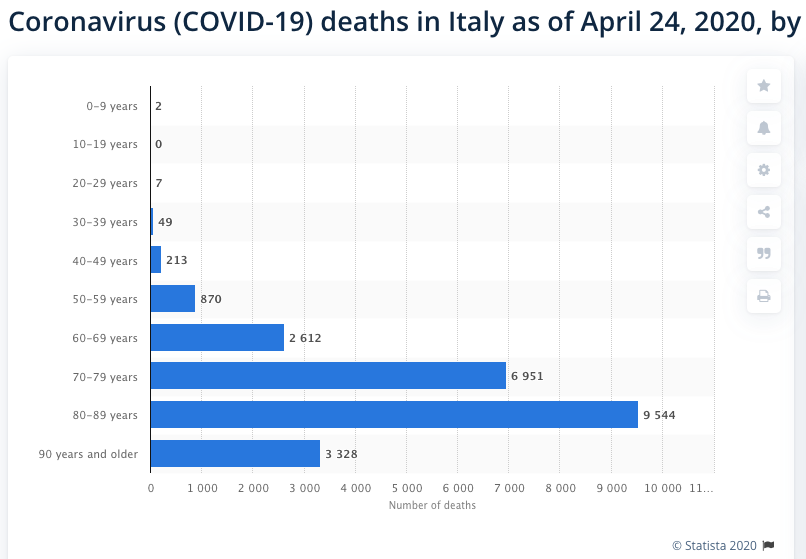

In [ ]:
deaths_df, df = load_nyc_age_comorbidity_death_data()
print(deaths_df.pivot(index='age_band', columns='comorbidity'))
# print(df)
deaths_df.groupby('age_band').sum()['deaths']

# nyc deaths-per-case
print('NYC deaths_per_case')
print(df['deaths'].sum() / df['cases'].sum())
# nyc deaths-per-case under 65
print('NYC deaths_per_case under 65')
u65 = df.loc[df['age_band'].isin(['0-17', '18-44', '45-64'])]
u65_deaths_per_case = u65['deaths'].sum() / u65['cases'].sum()
print(u65_deaths_per_case)
# nyc deaths-per-case under 45
print('NYC deaths_per_case under 45')
u45 = df.loc[df['age_band'].isin(['0-17', '18-44'])]
u45_deaths_per_case = u45['deaths'].sum() / u45['cases'].sum()
print(u45_deaths_per_case)
# among people who are dying, what fraction of them have comorbidities?
comorb = deaths_df.groupby('comorbidity').sum()
print('Percent of NYC deaths with comorbidity')
high_comorb_pct = (comorb.loc['yes', 'deaths'] + comorb.loc['unknown', 'deaths']) / comorb['deaths'].sum()
low_comorb_pct = comorb.loc['yes', 'deaths'] / comorb['deaths'].sum()
no_unk_comorb_pct = comorb.loc['yes', 'deaths'] / (comorb.loc['yes', 'deaths'] + comorb.loc['no', 'deaths'])
print(low_comorb_pct, no_unk_comorb_pct, high_comorb_pct)
